In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 5.3MB/s 
     |████████████████████████████████| 15.3MB 484kB/s 
     |████████████████████████████████| 6.5MB 44.9MB/s 


In [ ]:
from datetime import datetime
import pandas as pd
#import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import matplotlib.pyplot as plt
#import geopandas as gpd
from dateutil.parser import parse
from google.colab import drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
acs = pd.read_csv('/content/drive/My Drive/ACS_taxizone_cluster.csv')

In [ ]:
FHV = pd.read_csv('/content/drive/My Drive/FHV_ridership_dummies_no_acs.csv')

In [ ]:
FHV = FHV.drop(columns=['PUTime','DOTime'])

In [ ]:
FHV_sub1, FHV_sub2 = train_test_split(FHV ,random_state=1234,test_size=0.4)

In [ ]:
acs = acs.rename(columns={'cluster':'acs_cluster'})



# Clustering Pickup and Dropoff Locations


#### Pickup Locations

In [ ]:
np.setdiff1d(range(2,266), FHV.PULocationID.unique())

array([103, 104, 132, 264])

In [ ]:
np.setdiff1d(range(2,266), acs.LocationID.unique())

array([ 57, 104, 105, 264, 265])

In [ ]:
FHV_PULoc1 = FHV.groupby('PULocationID').sum().iloc[:,1:]
FHV_PULoc1['trip_count'] = FHV[['PULocationID','Duration']].groupby('PULocationID').count()

In [ ]:
PULocations = FHV_PULoc1.reset_index().merge(acs, left_on='PULocationID', right_on='LocationID', how='left').drop(columns=['LocationID','acs_cluster'])

In [ ]:
PULocations = PULocations.fillna(0)
#PULocations['cluster'] = PULocations['cluster'].mask((PULocations['hh_median_income'] == 0), 2)

In [ ]:
PULocations

,PULocationID,Duration,overnight,subway_x,subway_y,0,1,2,3,4,5,6,Lyft,Uber,Via,trip_count,race_white,transit_commute,transit_12_5,transit_60min+,hh_median_income,essential_workers
0,2,3.892017e+03,21,172.0,157.0,22,22,23,14,18,31,42,66,106,0,172,0.0,0.0,0.0,0.0,0.000000,0.0
1,3,1.395784e+06,7431,91369.0,84426.0,12231,12128,12832,13005,14512,14153,12508,26009,64592,768,91369,9220.0,5752.0,198.0,3922.0,78678.545455,3205.0
2,4,1.920232e+06,10041,109690.0,105319.0,13440,13299,14478,15544,18209,19060,15660,34811,69096,5783,109690,10121.0,7346.0,158.0,1255.0,48225.166667,2906.0
3,5,1.394319e+05,619,0.0,1373.0,1137,1099,1072,1237,1363,1371,1037,1717,6595,4,8316,24498.0,2602.0,28.0,2322.0,91298.500000,2364.0
4,6,2.750985e+05,1434,0.0,9445.0,2476,2493,2512,2678,2791,2697,2265,4992,12853,67,17912,11378.0,2640.0,36.0,1767.0,78611.000000,1490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,260,2.143701e+06,11215,136309.0,128742.0,19304,17211,18145,18710,21530,21952,19457,37645,97849,815,136309,18985.0,15002.0,385.0,2996.0,64765.833333,6166.0
256,261,1.356681e+06,4369,64794.0,59115.0,8702,8307,9239,9627,10125,10178,8616,17427,45997,1370,64794,3110.0,1903.0,30.0,175.0,171173.000000,366.0
257,262,1.896528e+06,4916,0.0,105708.0,14692,14987,16412,17414,18788,16699,13506,32449,72530,7519,112498,28931.0,13515.0,114.0,1176.0,113722.000000,3052.0
258,263,2.847594e+06,8246,164116.0,154410.0,21424,20856,23254,24334,27730,25644,20874,47124,108226,8766,164116,34746.0,20104.0,45.0,1643.0,116937.800000,4079.0


In [ ]:
scaler = StandardScaler()
scaled_PU = scaler.fit_transform(PULocations)

In [ ]:
##  KMeans Clustering for ACS + Trip Data

for n_clusters in range(2,13):
    km = KMeans(random_state=1234 ,n_clusters=n_clusters)
    res= km.fit(scaled_PU)   
    cluster_labels = res.labels_
    silhouette_avg = silhouette_score(scaled_PU, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.4404247865496471
For n_clusters = 3, the average silhouette_score is : 0.32535833911511935
For n_clusters = 4, the average silhouette_score is : 0.3033947489724114
For n_clusters = 5, the average silhouette_score is : 0.3114109721255114
For n_clusters = 6, the average silhouette_score is : 0.26567713441453
For n_clusters = 7, the average silhouette_score is : 0.25704619681145086
For n_clusters = 8, the average silhouette_score is : 0.24875448454415466
For n_clusters = 9, the average silhouette_score is : 0.25094865583409914
For n_clusters = 10, the average silhouette_score is : 0.24949218190422978
For n_clusters = 11, the average silhouette_score is : 0.23293441778614962
For n_clusters = 12, the average silhouette_score is : 0.24217062215123827


In [ ]:
km = KMeans(random_state=1234 ,n_clusters=5)
res= km.fit(scaled_PU)   
PULocations['PU_cluster'] = res.labels_

In [ ]:
PULocations.groupby('PU_cluster').mean()

,PULocationID,Duration,overnight,subway_x,subway_y,0,1,2,3,4,5,6,Lyft,Uber,Via,trip_count,race_white,transit_commute,transit_12_5,transit_60min+,hh_median_income,essential_workers
PU_cluster,,,,,,,,,,,,,,,,,,,,,,
0,156.060000,2.653044e+06,8217.820000,141381.560000,137728.860000,19225.720000,18864.640000,20763.340000,21658.260000,23684.000000,23169.860000,19428.520000,40867.480000,100920.780000,5006.080000,146794.340000,15778.020000,7772.200000,41.000000,719.700000,126258.593905,2113.100000
1,131.216216,3.921105e+06,20974.135135,238682.270270,225595.351351,31361.540541,29788.567568,32446.675676,33543.351351,38314.810811,39059.324324,34168.000000,67231.432432,168334.675676,3116.162162,238682.270270,19367.864865,17418.378378,507.513514,5719.567568,57321.511272,7693.837838
2,93.916667,7.145393e+06,38327.083333,414233.750000,397428.166667,54301.416667,51708.083333,56124.500000,58217.333333,66073.083333,67906.083333,59903.250000,131138.500000,276687.583333,6407.666667,414233.750000,18556.500000,25647.000000,826.250000,8174.083333,51630.766314,10350.000000
3,136.206897,1.965210e+06,10147.551724,112258.741379,108737.689655,16674.224138,15699.344828,16824.724138,17209.068966,19147.620690,18631.741379,16606.879310,32632.500000,87307.224138,853.879310,120793.603448,16524.672414,10613.379310,383.793103,5310.965517,57832.465456,5832.586207
4,125.786408,5.721935e+05,2503.951456,23969.485437,25720.786408,4553.737864,4262.165049,4606.368932,4756.757282,5277.368932,5323.844660,4646.932039,9666.864078,23393.495146,366.815534,33427.174757,8840.737864,3059.961165,75.058252,1627.854369,66661.366819,1704.524272


#### Dropoff Locations

In [ ]:
FHV_DOLoc1 = FHV.groupby('DOLocationID').sum().iloc[:,1:]
FHV_DOLoc1['trip_count'] = FHV[['DOLocationID','Duration']].groupby('DOLocationID').count()

In [ ]:
DOLocations = FHV_DOLoc1.reset_index().merge(acs, left_on='DOLocationID', right_on='LocationID', how='left')

In [ ]:
DOLocations = DOLocations.drop(columns=['LocationID','acs_cluster'])

In [ ]:
DOLocations = DOLocations.fillna(0)
DOLocations

,DOLocationID,Duration,overnight,subway_x,subway_y,0,1,2,3,4,5,6,Lyft,Uber,Via,trip_count,race_white,transit_commute,transit_12_5,transit_60min+,hh_median_income,essential_workers
0,2,4.871017e+03,27,185.0,203.0,25,20,26,23,29,36,44,75,124,4,203,0.0,0.0,0.0,0.0,0.000000,0.0
1,3,1.299787e+06,6985,85666.0,86697.0,11547,11427,12190,12486,13762,13796,11489,22918,63022,757,86697,9220.0,5752.0,198.0,3922.0,78678.545455,3205.0
2,4,1.604348e+06,7980,94782.0,96676.0,11966,11226,12358,12910,15420,17655,15141,30428,61420,4828,96676,10121.0,7346.0,158.0,1255.0,48225.166667,2906.0
3,5,1.268784e+05,663,1299.0,0.0,974,1000,972,1145,1199,1283,1021,1496,6066,32,7594,24498.0,2602.0,28.0,2322.0,91298.500000,2364.0
4,6,2.597085e+05,1332,9838.0,0.0,2449,2470,2636,2698,2860,2538,2086,4445,13171,121,17737,11378.0,2640.0,36.0,1767.0,78611.000000,1490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,261,1.214763e+06,5128,62646.0,64288.0,9072,8604,9197,9574,10315,9620,7906,17445,45229,1614,64288,3110.0,1903.0,30.0,175.0,171173.000000,366.0
257,262,1.641266e+06,5467,94997.0,0.0,12895,12557,13765,14150,15074,14886,14175,27342,63599,6561,97502,28931.0,13515.0,114.0,1176.0,113722.000000,3052.0
258,263,2.505227e+06,8752,149211.0,152989.0,19956,19576,21555,21731,24344,24167,21660,44636,100650,7703,152989,34746.0,20104.0,45.0,1643.0,116937.800000,4079.0
259,264,1.821667e+01,0,1.0,0.0,0,0,0,1,0,0,0,1,0,0,1,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
scaled_DO = scaler.fit_transform(DOLocations)

In [ ]:
##  KMeans Clustering for ACS + Trip Data

for n_clusters in range(2,13):
    km = KMeans(random_state=1234 ,n_clusters=n_clusters)
    res= km.fit(scaled_DO)   
    cluster_labels = res.labels_
    silhouette_avg = silhouette_score(scaled_DO, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.45146056182575456
For n_clusters = 3, the average silhouette_score is : 0.328630606566722
For n_clusters = 4, the average silhouette_score is : 0.3095321318862465
For n_clusters = 5, the average silhouette_score is : 0.3187518988459459
For n_clusters = 6, the average silhouette_score is : 0.28423089035004884
For n_clusters = 7, the average silhouette_score is : 0.2477561298727325
For n_clusters = 8, the average silhouette_score is : 0.24702983621597938
For n_clusters = 9, the average silhouette_score is : 0.23531643552815962
For n_clusters = 10, the average silhouette_score is : 0.24070919914869784
For n_clusters = 11, the average silhouette_score is : 0.2389772490744592
For n_clusters = 12, the average silhouette_score is : 0.2334210977274703


In [ ]:
km = KMeans(random_state=1234 ,n_clusters=5)
res= km.fit(scaled_DO)   
DOLocations['DO_cluster'] = res.labels_

# Split Dataset into smaller random samples for testing


In [ ]:
FHV_sub1, FHV_sub2 = train_test_split(FHV ,random_state=1234,test_size=0.4)

#### Using only ACS Clusters intead of individual ACS info for PU and DO Zones

In [ ]:
# Merge ACS clusters with FHV ride data

FHV_merged = FHV_sub2.merge(acs[['LocationID','acs_cluster']], left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(acs[['LocationID','acs_cluster']], left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')

In [ ]:
# Merge Taxi Zone clusters with FHV ride data

FHV_merged = FHV_merged.merge(PULocations[['PULocationID','PU_cluster']], on='PULocationID', how='left')\
    .merge(DOLocations[['DOLocationID','DO_cluster']], on='DOLocationID', how='left')

In [ ]:
FHV_merged.dropna(inplace=True)

In [ ]:
FHV_merged = FHV_merged.rename(columns={'acs_cluster_x':'PU_acs','acs_cluster_y':'DO_acs'})

## Feature Selection and Modelling

In [ ]:
# Train-Test Split

X = FHV_merged.drop(columns=['overnight','PULocationID','DOLocationID'])
y = FHV_merged['overnight']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1234,test_size=0.4)

In [ ]:
## Standardizing the Data
scaler = StandardScaler()
scale = scaler.fit(X_train)
XS_train = scale.transform(X_train)
XS_test = scale.transform(X_test)

In [ ]:
## First train the model using only "Duration" variable

X_train_Duration = np.array(X_train['Duration']).reshape(-1,1)
X_test_Duration = np.array(X_test['Duration']).reshape(-1,1)

dt=DecisionTreeClassifier()
dt.fit(X_train_Duration,y_train)
print('In Sample Accuracy:',dt.score(X_train_Duration,y_train))
print('Out Of Sample Accuracy:',dt.score(X_test_Duration,y_test))

In Sample Accuracy: 0.9208318913303852
Out Of Sample Accuracy: 0.9207427580679458


In [ ]:
# Decision Tree Classifier

dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('In Sample Accuracy:',dt.score(XS_train,y_train))
print('Out Of Sample Accuracy:',dt.score(XS_test,y_test))

IS R2: 0.8412027960704096
OS R2: 0.8411935489147325


In [ ]:
# Random Forest Classifier

rf = RandomForestClassifier(n_estimators=50, oob_score=True)
rf.fit(X_train,y_train)
print('In Sample Accuracy:',rf.score(XS_train,y_train))
print('Out Of Sample Accuracy:',rf.score(XS_test,y_test))

In Sample Accuracy: 0.9191464687432145
Out Of Sample Accuracy: 0.9191027937255671


<BarContainer object of 17 artists>

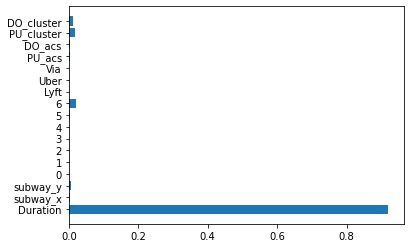

In [ ]:
plt.barh(X_train.columns, rf.feature_importances_)

### Train Model With ONLY "Duration" Variable

In [ ]:
## train the model using only "Duration" variable

X_train_Duration = np.array(X_train['Duration']).reshape(-1,1)
X_test_Duration = np.array(X_test['Duration']).reshape(-1,1)

dt=DecisionTreeClassifier()
dt.fit(X_train_Duration,y_train)
print('In Sample Accuracy:',dt.score(X_train_Duration,y_train))
print('Out Of Sample Accuracy:',dt.score(X_test_Duration,y_test))

In Sample Accuracy: 0.9208318913303852
Out Of Sample Accuracy: 0.9207427580679458


### Train Model Without "Duration" Variable

In [ ]:
# Train-Test Split Without "Duration" Variable

X = FHV_merged.drop(columns=['overnight','PULocationID','DOLocationID','Duration'])
y = FHV_merged['overnight']

X_train_no_dur, X_test_no_dur, y_train, y_test = train_test_split(X,y,random_state=1234,test_size=0.4)

In [ ]:
# Decision Tree Classifier w/o Duration

dt=DecisionTreeClassifier()
dt.fit(X_train_no_dur,y_train)
print('In Sample Accuracy:',dt.score(X_train_no_dur,y_train))
print('Out Of Sample Accuracy:',dt.score(X_test_no_dur,y_test))

In Sample Accuracy: 0.9208290289062582
Out Of Sample Accuracy: 0.9207480739977427


<BarContainer object of 16 artists>

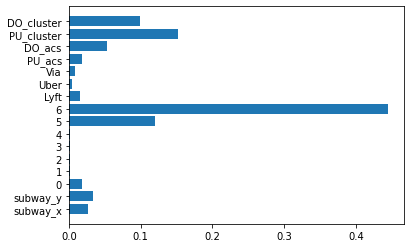

In [ ]:
plt.barh(X_train_no_dur.columns, dt.feature_importances_)

### Train Model With Clusters Only

In [ ]:
# Train-Test Split With Clusters Only

X = FHV_merged[['DO_cluster','PU_cluster','PU_acs','DO_acs']]
y = FHV_merged['overnight']

X_train_clusts, X_test_clusts, y_train, y_test = train_test_split(X,y,random_state=1234,test_size=0.4)

In Sample Accuracy: 0.9208267117057745
Out Of Sample Accuracy: 0.9207503230449646


<BarContainer object of 4 artists>

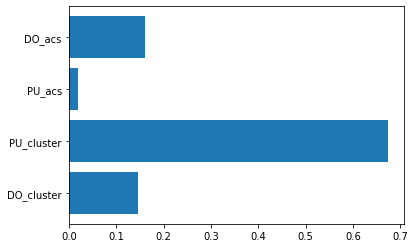

In [ ]:
# Decision Tree Classifier w/o Duration

dt=DecisionTreeClassifier()
dt.fit(X_train_clusts,y_train)
print('In Sample Accuracy:',dt.score(X_train_clusts,y_train))
print('Out Of Sample Accuracy:',dt.score(X_test_clusts,y_test))

plt.barh(X_train_clusts.columns, dt.feature_importances_)

Split Dataset into smaller random samples for testing



In [ ]:
FHV_samp1, FHV_samp2 = train_test_split(FHV_merged, test_size=0.4, random_state = 1234)

NameError: ignored

In [ ]:
FHV_clusters = pd.read_csv('/content/drive/My Drive/FHV_preprocessed_sample.csv')
FHV_clusters = FHV_clusters

In [ ]:
FHV_clusters = FHV_clusters.drop(columns='Unnamed: 0')

In [ ]:
# Train-Test Split

X = FHV_clusters.drop(columns=['overnight','DOLocationID','PULocationID'])
y = FHV_clusters['overnight']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1234,test_size=0.4)

In [ ]:
## Standardizing the Data
scaler = StandardScaler()
scale = scaler.fit(X_train)
XS_train = scale.transform(X_train)
XS_test = scale.transform(X_test)

In [ ]:
# Decision Tree Classifier

dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('IS R2:',dt.score(XS_train,y_train))
print('OS R2:',dt.score(XS_test,y_test))

IS R2: 0.8567375229351141
OS R2: 0.8559722484460712


In [ ]:
# Random Forest Classifier

rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train,y_train)
print('IS R2:',dt.score(XS_train,y_train))
print('OS R2:',dt.score(XS_test,y_test))

IS R2: 0.8567375229351141
OS R2: 0.8559722484460712


In [ ]:
# GridSearch for best RF parameters

param_grid = {'max_depth':range(2,30)}
rf = RandomForestClassifier(n_estimators=20)
gs = GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
rs = gs.fit(XS_train,y_train)
pred=rs.predict(XS_test)
print(rs.best_params_)
print(accuracy_score(np.array(y_test),pred))

{'max_depth': 16}
0.9212169521937953
